# Introduction to image classification using camera trap images

Camera traps are a tool used by conservationists to study and monitor a wide range of ecologies while limiting human interference. However, they also generate a vast amount of data that quickly exceeds the capacity of humans to sift through. That's where machine learning can help! Advances in computer vision can help automate tasks like species detection and identification, so that humans can spend more time learning from and protecting these ecologies.

This post walks through an initial approach for the [Conservision Practice Area](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/) challenge on DrivenData, a practice competition where you identify animal species in a real world dataset of wildlife images from [Tai National Park](https://en.wikipedia.org/wiki/Ta%C3%AF_National_Park) in Côte d'Ivoire. This is a practice competition designed to be accessible to participants at all levels. That makes it a great place to dive into the world of data science competitions and computer vision.

![camera trap images](https://drivendata-public-assets.s3.amazonaws.com/conservision-leopard-collage.jpg)

We will go through the following steps in order to train a PyTorch model that can be used to identify the species of animal in a given image:
1. Set up your environment (feel free to skip)
2. Download the data
3. Explore the data
4. Split into train and evaluation sets
5. Build the Model
6. Training
7. Evaluation
8. Create submission

The only pre-requisite is a basic familiarity with Python and some of the basic concepts behind deep learning. We'll guide you step-by-step through the rest.

Let's get started!

## 1. Set up your environment
Feel free to skip this step if you already have an environment set up. 

The folks on our team typically use conda to manage environments. Once you have [conda installed](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) you can create a new "conserviz" environment (name it whatever you like) with:
```
conda create -n conserviz python=3.8
```

Then we activate the new environment and install the required libraries with pip. The pip command below includes all the libraries we'll need for this notebook. Launch a jupyter notebook from this new environment.
```
conda activate conserviz
pip install pandas matplotlib Pillow tqdm scikit-learn torch torchvision
```



## 2. Download the data
Download the competition data from the [Data Download](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/) page. You'll need to first register for the competition by clicking on "Compete" and agreeing to the rules.

The `competition.zip` file contains everything you need to take part in this competition, including this notebook `benchmark.ipynb`. Unzip the archive into a location of your choice. The file structure should look like this:
```
├── benchmark.ipynb
├── submission_format.csv
├── test_features
│   ├── ZJ000000.jpg
│   ├── ZJ000001.jpg
│   └── ...
├── test_features.csv
├── train_features
│   ├── ZJ016488.jpg
│   ├── ZJ016489.jpg
│   └── ...
├── train_features.csv
└── train_labels.csv
```

Next, let's import some of the usual suspects:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm

Read in the train and test CSVs first and see what they look like.

In [ ]:
train_features = pd.read_csv("train_features.csv", index_col="id")
test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id")

The `features` CSVs contain the image ID, filepath and site ID for each image. 

In [ ]:
train_features.head()

In [ ]:
test_features.head()

The `train_labels` CSV is an indicator matrix of the species identified in each of the training images. Some images are labeled as "blank" if no animal was detected.

In [ ]:
train_labels.head()

Let's store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [ ]:
species_labels = sorted(train_labels.columns.unique())
species_labels

## 3. Explore the data

Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label. You can try changing the `random_state` variable to display a new set of images.

In [ ]:
import matplotlib.image as mpimg

random_state = 42

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

Can you spot the animals? I'm still not sure where the rodent is. Birds can be tough to spot too.

Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

In [ ]:
train_labels.sum().sort_values(ascending=False)

In [ ]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

In case you're curious, this distribution is not exactly what we find in the wild. The competition dataset has been curated a little bit to produce a more uniform distribution than we would see in the actual data.

There's a lot more data exploration to do. For example, you might also want to look at the distribution of image dimensions or camera trap sites. But since our primary goal here is to develop a benchmark, let's move on to the modeling!

## 4. Split into train and evaluation sets
First, we'll need to split the images into train and eval sets. We'll put aside 25% of the data for evaluation and stratify by the target labels to ensure we have similar relative frequencies of each class in the train and eval sets.

For the purposes of this benchmark, we're also going to limit ourselves to a 50% subset of the training data, just so that things run faster. But feel free to adjust `frac` or remove it entirely if you want to run the training on the full set.

In [ ]:
from sklearn.model_selection import train_test_split

frac = 1

y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

Here's what `x_train` and `y_train` look like now:

In [ ]:
x_train.head()

In [ ]:
y_train.head()

In [ ]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

Next, let's validate that our split has resulted in roughly similar relative distributions of species across the train and eval sets (because of how we passed `stratify=y` above).

In [ ]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Good, this looks as expected.

## 5. Build the Model

Now we can start building our model.

### The Dataset

First, we'll create an `ImagesDataset` class that will define how we access our data and any transformations we might want to apply. 

This new class will inherit from the PyTorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class, but we'll also need to define our own `__init__`, `__len__` and `__getitem__` **special methods**:
* **`__init__`** will instantiate the dataset object with two dataframes: an `x_train` df containing image IDs and image file paths, and a `y_train` df containing image IDs and labels. This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`.
* **`__getitem__`** will define how we access a sample from the data. This method gets called whenever we use an indexing operation like `dataset[index]`. In this case, whenever accessing a particular image sample (for example, to get the first image we'd do `dataset[0]`) the following will happen:
  * look up the image filepath using the index
  * load the image with [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  * apply some transformations (more on this below)
  * return a dictionary containing the image ID, the image itself as a Tensor, and a label (if it exists)
* **`__len__`** simply returns the size of the dataset, which we do by calling `len` on the input dataframe.

In [ ]:
from PIL import Image, ImageFilter, ImageEnhance
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, ConcatDataset
from torchvision.transforms import v2 as transforms

def custom_preprocessing(image):
    # Convertir a escala de grises puede ayudar a enfocarse en la textura y forma
    image = ImageEnhance.Color(image).enhance(0.8)  # Ligeramente menos saturación
    image = ImageEnhance.Brightness(image).enhance(1.1)  # Aumentar ligeramente el brillo
    image = ImageEnhance.Contrast(image).enhance(1.2)  # Aumentar el contraste para resaltar características
    
    # Aplicar un suave enfoque puede ayudar a resaltar los animales contra fondos complejos
    image = image.filter(ImageFilter.UnsharpMask(radius=1, percent=50))
    
    return image

def data_augmentation(image):
    # Transformaciones aleatorias
    transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
        transforms.RandomRotation(degrees=12),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomEqualize(p=0.33),
    ])
    
    # Aplicar transformaciones aleatorias
    augmented_image = transform(image)
    
    return augmented_image

In [ ]:
# import torch
# import torchvision.transforms as transforms
# import torchvision.models as models
# import matplotlib.pyplot as plt

# # Verificar si hay una GPU disponible y configurar el dispositivo
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Cargar el modelo DeepLabV3 pre-entrenado en COCO y moverlo a la GPU si está disponible
# model = models.segmentation.deeplabv3_resnet101(pretrained=True)
# model.to(device)
# model.eval()

# # Definir transformaciones para preprocesar la imagen
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Función para segmentar la imagen
# def segment_image(image_path):
#     image = Image.open(image_path).convert("RGB")
#     image_tensor = transform(image).unsqueeze(0).to(device)

#     with torch.no_grad():
#         output = model(image_tensor)['out'][0]

#     # Convertir la salida en una máscara binaria
#     mask = (output.argmax(0) == 17)  # Clase de personas en COCO

#     return mask

# # Ruta de la imagen de entrada
# image_path = x_train.iloc[667]['filepath']

# # Segmentar la imagen
# mask = segment_image(image_path)

# # Mostrar la imagen original y la máscara segmentada
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(Image.open(image_path))
# plt.title("Imagen Original")
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(mask.cpu(), cmap='gray')
# plt.title("Máscara Segmentada")
# plt.axis('off')

# plt.show()

In [ ]:
# Suponiendo que `x_train` es tu DataFrame con las columnas 'id' y 'filepath'
# y que deseas cargar la primera imagen del DataFrame

# Obtener la ruta del archivo de la primera imagen
file_path = x_train.iloc[5]['filepath']
print(y_train.iloc[0])
# Cargar la imagen utilizando PIL
imagen_pr_noche = Image.open(file_path)

# Obtener la ruta del archivo de la primera imagen
file_path = x_train.iloc[0]['filepath']

# Cargar la imagen utilizando PIL
imagen_pr_dia = Image.open(file_path)

# Mostrar las imágenes
plt.figure(figsize=(15, 8))

# Subtrama 1 para la primera imagen
plt.subplot(2, 2, 1)
plt.imshow(imagen_pr_dia)
plt.title("Imagen sin preprocesar")

# Subtrama 2 para la segunda imagen
plt.subplot(2, 2, 2)
plt.imshow(custom_preprocessing(imagen_pr_dia))
plt.title("Imagen preprocesada")

# Subtrama 1 para la primera imagen
plt.subplot(2, 2, 3)
plt.imshow(imagen_pr_noche)
plt.title("Imagen sin preprocesar")

# Subtrama 2 para la segunda imagen
plt.subplot(2, 2, 4)
plt.imshow(custom_preprocessing(imagen_pr_noche))
plt.title("Imagen preprocesada")

plt.show()


In [ ]:
class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None, preprocessing=None, augmentation=None):
        self.data = x_df
        self.label = y_df
        self.preprocessing = preprocessing
        self.augmentation = augmentation
        self.transform = transforms.Compose(
            [
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")

        # Preprocesamiento de la imagen
        if self.preprocessing is not None:
            image = self.preprocessing(image)
        
        # Aumento de datos
        if self.augmentation is not None:
            image = self.augmentation(image)
        
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

Notice that we are also defining a set of **transformations**, which are defined in the `__init__` and called in the `__getitem__` special methods. These are applied to each image before returning it. Here's what each of those transformations do and why:

* `transforms.Resize((224, 224))` ResNet50 was trained on images of size 224x224 so we resize to the same dimensions here. See [pytorch docs](https://pytorch.org/vision/stable/models.html) and the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).
* `transforms.ToTensor()` converts the image to a tensor. Since we are passing in a PIL Image at this point, PyTorch can recognize it as an RGB image and will automatically convert the input values which are in the range [0, 255] to a range of [0, 1]. See more from the [PyTorch docs](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html).
* `transforms.Normalize(...)` normalizes the image tensors using the mean and standard deviation of ImageNet images. Because this transformation was applied to images when training the ResNet model, we want to do the same here with our images. See more from the [PyTorch docs on pretrained models](https://pytorch.org/vision/stable/models.html).

### The DataLoader
Next, we need to load the dataset into a dataloader. The `DataLoader` class lets us iterate through our dataset in batches.

In [ ]:
from torch.utils.data import DataLoader

def create_combined_dataset(original_dataset, num_augmentations, augmentation_functions):
    """
    Creates a combined dataset with the original dataset and multiple augmented versions.

    Args:
        original_dataset: The original dataset without augmentation.
        num_augmentations: The number of augmented datasets to create.
        augmentation_functions: A list of augmentation functions (e.g., transforms).

    Returns:
        combined_dataset: A ConcatDataset with the original and augmented datasets.
    """

    datasets = [original_dataset]
    for i in range(num_augmentations):
        augmented_dataset = ImagesDataset(
            x_train, y_train, preprocessing=custom_preprocessing,
            augmentation=augmentation_functions,
        )
        datasets.append(augmented_dataset)

    combined_dataset = ConcatDataset(datasets)
    return combined_dataset

In [ ]:
train_dataset_original = ImagesDataset(x_train, y_train, preprocessing=custom_preprocessing, augmentation=None)
train_dataset=create_combined_dataset(train_dataset_original, 2, augmentation_functions=data_augmentation)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#Eval
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=64)

The data pieces are now largely in place!

## 6. Training
Now it's time to start building our model and then training it.

We'll use a pretrained ResNet50 model as our backbone. ResNets are one of the more popular networks for image classification tasks. The pretrained model outputs a 2048-dimension embedding, which we will then connect to two more dense layers, with a ReLU and Dropout step in between. 

These final layers, defined in `model.fc`, are the new "head" of our model, and allow us to transform the image embeddings produced by the pretrained "backbone" into the 8-dimensional output required to learn the species classification task we're tackling here. Prior to redefining it below, `model.fc` would be the final, dense layer connecting the 2048-dimension embedding to a 1000-dimension output (corresponding to the 1000 ImageNet classes that the pretrained model was trained on). We will instead prepare the model for the current task by redefining `model.fc` to produce an 8-dimensional output corresponding to our 8 species classes (including blanks). 

We'll also add a couple more layers in between. The `ReLU` layer introduces non-linearity into the model head, in effect activating important features and suppressing noise. And the `Dropout` layer is a commonly used regularization component that randomly drops some nodes from the previous layer's outputs (10% of nodes in this case) during each training step, mitigating our risk of overfitting.

In [ ]:
from torch import nn
import torchvision.models as models
import torch.nn.functional as F

# model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
weights=models.ResNet152_Weights.DEFAULT
model = models.resnet152(weights=weights)

# Congelar todas las capas excepto las especificadas
for name, param in model.named_parameters():
    if 'layer4' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


# Modificamos la última capa completamente conectada del modelo
model.fc = nn.Sequential(
    nn.Linear(2048, 1024),  # Aumentamos la capacidad aquí
    nn.BatchNorm1d(1024),   # Añadimos BatchNorm
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),        # Ajustamos la tasa de abandono para la primera capa
    nn.Linear(1024, 256),   # Ajustamos el tamaño de salida para permitir una representación más detallada
    nn.BatchNorm1d(256),    # Añadimos BatchNorm
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),        # Ajustamos la tasa de abandono para la segunda capa
    nn.Linear(256, 8)       # Ajustamos según el número de clases de tu problema específico
)


# Verificar que las capas estén congeladas correctamente
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

### Define our loss function
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

### Train the model
We're now ready to train our model!

We'll start simple and just run it for one epoch, but feel free to run it for more `num_epochs` if you've got the time. We hope to see a decreasing loss as training progresses, which will provide some evidence that the model is learning. Note that we haven't frozen any weights in the pretrained model, a choice which you may want to revisit and we discuss in a little more detail below.

For each epoch we'll iterate through the batches, and for each batch we'll do the following:
1. Zero out the gradients. PyTorch will sum the gradients from past batches when doing its backward pass, so in order to make sure we are only using the gradients computed for the current batch, we zero out the gradients at the beginning of each batch.
2. Run the forward pass.
3. Compute the loss and track it.
4. Compute our gradients and update our weight parameters.

In [ ]:
# import torch.optim as optim

# criterion = nn.focal_loss()
# optimizer = optim.SGD(model.parameters(), lr=0.003499, momentum=0.909431)

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from optuna import Trial, create_study

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming `model` and `criterion` are defined somewhere earlier in your code
model.to(device)  # Move the model to the GPU
criterion = nn.CrossEntropyLoss()

# Define hyperparameter ranges
# learning_rate_range = (0.075)
momentum_range = (0.85, 0.95)
# num_epochs_range = (3)
num_epochs=3

def objective(trial):
    global model, train_dataloader, eval_dataloader

    # Sample hyperparameters from Optuna
    # learning_rate = trial.suggest_float("learning_rate", *learning_rate_range)
    momentum = trial.suggest_float("momentum", *momentum_range)
    # num_epochs = trial.suggest_int("num_epochs", *num_epochs_range)

    # Define and initialize optimizer based on sampled hyperparameters
    optimizer = optim.SGD(model.parameters(), lr=0.075, momentum=momentum)


    tracking_loss = {}
    tracking_loss_ev = {} 

    # print(f"Learning rate: {learning_rate}")
    # print(f"Number of epochs: {num_epochs}")
    print(f"Momentum: {momentum}")
    
    for epoch in range(1, num_epochs + 1):
        print(f"Starting epoch {epoch}")
        steps_per_epoch = len(train_dataloader)
        train_loss = 0.0  # Initialize accumulated train loss
        quarter_step = steps_per_epoch // 4
        model.train()
        
        # iterate through the dataloader batches. tqdm keeps track of progress.
        for batch_n, batch in tqdm(
            enumerate(train_dataloader), total=len(train_dataloader), # Desactiva la impresión al final
        smoothing=0.25,
        colour="green", # Color agradable
        ):
    
            # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
            optimizer.zero_grad()
        
            # 2) run the foward step on this batch of images
            outputs = model(batch["image"].to(device))
        
            # 3) compute the loss
            loss = criterion(outputs, batch["label"].to(device))
    
            # 4) compute our gradients
            loss.backward()
            # update our weights
            optimizer.step()

        epoch_progress = (batch_n + 1) / steps_per_epoch
        tracking_loss[epoch+epoch_progress] = float(loss)  # Average loss up to this point
        
        # Evaluate the model on the evaluation dataset
        model.eval()  # Switch to evaluation mode
    
        with torch.no_grad():
            eval_loss = 0
            total_batches = 0  # Contador para el número total de lotes
            
            for batch in tqdm(eval_dataloader, disable=True):
                # 1) run the forward step
                logits = model.forward(batch["image"].to(device))
                # 3) compute the loss
                eval_loss += float(criterion(logits, batch["label"].to(device)))

                print(float(eval_loss))
    # Return evaluation loss as the objective function for Optuna
    return float(eval_loss)

In [ ]:
# # Create Optuna study and optimize
# study = create_study(direction="minimize")
# study.optimize(objective, n_trials=15)  # Adjust n_trials as needed

# # Access best trial and its hyperparameters
# best_trial = study.best_trial
# # best_learning_rate = best_trial.params["learning_rate"]
# best_momentum = best_trial.params["momentum"]
# # best_epoch= best_trial.params["epochs"]

# # print(f"Best learning rate: {best_learning_rate}")
# print(f"Best momentum: {best_momentum}")
# # print(f"Best epochs: {best_epoch}")

# # Train the model again with optimal hyperparameters
# # ... (similar training loop using best_learning_rate and best_momentum) ...

In [ ]:
# df_study=study.trials_dataframe()
# df_study

In [ ]:
# import matplotlib.pyplot as plt

# # Ordenamos el dataframe por la columna "params_learning_rate"
# df_study = df_study.sort_values('params_learning_rate')

# # Gráfica params_learning_rate vs value
# plt.subplot(121)
# plt.plot(df_study['params_learning_rate'], df_study['value'], marker='o', label='params_learning_rate vs value')
# plt.xlabel('params_learning_rate')
# plt.ylabel('value')
# plt.legend()

# # Ordenamos el dataframe por la columna "params_learning_rate"
# df_study = df_study.sort_values('params_momentum')

# # Gráfica params_momentum vs value
# plt.subplot(122)
# plt.plot(df_study['params_momentum'], df_study['value'], marker='x', label='params_momentum vs value')
# plt.xlabel('params_momentum')
# plt.ylabel('value')
# plt.legend()

# # Ajusta el layout para que las gráficas no se superpongan
# plt.tight_layout()

# # Muestra las gráficas
# plt.show()

### Entrenamiento

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

# # Definir los pesos de clase como un diccionario
# class_weights = {'blank': 2.0, 'monkey_prosimian': 2.0, 'antelope_duiker': 2.0,
#                  'leopard': 1.0, 'civet_genet': 1.0, 'rodent': 1.0,
#                  'bird': 1.0, 'hog': 1.0}

# # Convertir los pesos de clase en un tensor
# weights = torch.tensor([class_weights[label] for label in sorted(class_weights.keys())])

# Definir el criterio de pérdida con los pesos de clase
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.909431, weight_decay=0.005)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.000025, weight_decay=0.0001)  # Add weight decay

def early_stopping(current_val_loss, previous_val_loss, min_delta, tolerance, counter):
    if (current_val_loss - previous_val_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
            return "True"
        return counter
    return "False"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming `model` and `criterion` are defined somewhere earlier in your code
model.to(device)  # Move the model to the GPU

In [ ]:
import copy

num_epochs = 5

tracking_loss = pd.DataFrame(columns=['Epoch', 'Loss'])
tracking_loss_ev = pd.DataFrame(columns=['Epoch', 'Loss'])

steps_per_epoch = len(train_dataloader)
quarter_step = steps_per_epoch // 10

counterr = 0
break_outer_loop = False
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.72)

# Inicializar el seguimiento de la mejor pérdida de evaluación y el mejor modelo
best_eval_loss = float('inf')  # Infinito
best_model_state = copy.deepcopy(model.state_dict())  # Copia profunda del estado del modelo

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    train_loss = 0.0  # Initialize accumulated train loss

    train_dataset_original = ImagesDataset(x_train, y_train, preprocessing=custom_preprocessing, augmentation=None)
    train_dataset=create_combined_dataset(train_dataset_original, 2, augmentation_functions=data_augmentation)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    model.train()
    
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader), colour="cyan"
    ):
        optimizer.zero_grad()
        outputs = model(batch["image"].to(device))
        loss = criterion(outputs, batch["label"].to(device))
        
        if (batch_n == 0) or (batch_n % quarter_step == 0) or (batch_n == steps_per_epoch - 1):
            epoch_progress = (batch_n + 1) / steps_per_epoch
            tracking_loss.loc[len(tracking_loss)] = [epoch+epoch_progress-1, float(loss)]
            eval_loss = 0.0
            eval_correct = 0
            model.eval()
            with torch.no_grad():
                total_batches = 0
                for batch in tqdm(eval_dataloader, disable=True):
                    logits = model.forward(batch["image"].to(device))
                    eval_loss += float(criterion(logits, batch["label"].to(device)))
                    total_batches += 1
                avg_eval_loss = float(eval_loss) / total_batches
                tracking_loss_ev.loc[len(tracking_loss_ev)] = [epoch+epoch_progress-1, avg_eval_loss]
            
            scheduler.step(avg_eval_loss)
            print(f"Epoch {epoch} - Train Loss: {float(loss)}")
            print(f"Epoch {epoch} - Eval Loss: {avg_eval_loss}")
            print(f"Counter {counterr}")

            # Actualizar el mejor modelo si necesario
            if avg_eval_loss < best_eval_loss:
                best_eval_loss = avg_eval_loss
                best_model_state = copy.deepcopy(model.state_dict())

            # early stopping
            if (epoch>1) and ((epoch_progress<0.97) or (epoch_progress>0.03) or epoch_progress==0):
                # Obtener el valor de pérdida correspondiente a la última fila
                ultimo_valor_loss = tracking_loss_ev.iloc[-1]['Loss']
                # Obtener el valor de pérdida correspondiente a la penúltima fila
                penultimo_valor_loss = tracking_loss_ev.iloc[-2]['Loss']
    
                aux=early_stopping(ultimo_valor_loss, penultimo_valor_loss, min_delta=0.0001, tolerance = 5, counter=counterr)
                
                if aux=="True":
                    print("Early Stopping triggered")
                    break_outer_loop = True
                    break
                elif aux=="False":
                    counterr=0
                else:
                    counterr=aux

        loss.backward()
        optimizer.step()

    if break_outer_loop:
        break

# Cargar el mejor estado del modelo
model.load_state_dict(best_model_state)


In [32]:
# Cargar el mejor estado del modelo
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [113]:
pd.set_option('display.max_rows', None)
display(tracking_loss_ev)

,Epoch,Loss
0,0.001724,2.077825
1,0.101724,1.562215
2,0.201724,1.236332
3,0.301724,1.135002
4,0.401724,1.062954
5,0.501724,1.006894
6,0.601724,0.956060
7,0.701724,1.098709
8,0.801724,0.934384
9,0.901724,1.015221


In [33]:
pd.set_option('display.max_rows', None)
display(tracking_loss_ev)

,Epoch,Loss
0,0.001724,2.084338
1,0.101724,1.414764
2,0.201724,1.227736
3,0.301724,1.091601
4,0.401724,1.037350
5,0.501724,0.949937
6,0.601724,0.964541
7,0.701724,0.934527
8,0.801724,0.869313
9,0.901724,0.849750


Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

In [81]:
tracking_loss_ev["loss_smoothed"] = tracking_loss_ev["Loss"].rolling(window=5).mean()
tracking_loss["loss_smoothed"] = tracking_loss["Loss"].rolling(window=5).mean()

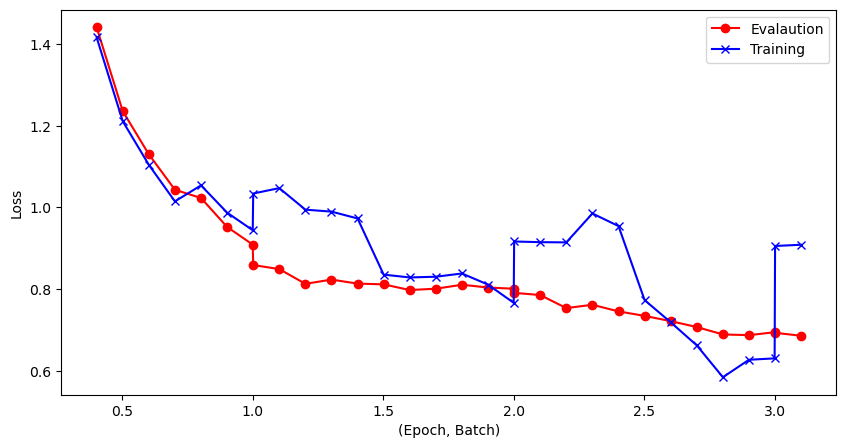

In [82]:
# tracking_loss = pd.Series(tracking_loss)
# tracking_loss_ev = pd.Series(tracking_loss_ev)

plt.figure(figsize=(10, 5))
plt.plot(tracking_loss_ev['Epoch'], tracking_loss_ev['loss_smoothed'], color="red", marker="o", label="Evalaution")
# plt.rolling(center=True, min_periods=1, window=10).mean().plot(
#     label="loss (moving avg)"
# )
plt.plot(tracking_loss['Epoch'], tracking_loss['loss_smoothed'], color="blue", marker="x", label="Training")
# plt.rolling(center=True, min_periods=1, window=10).mean().plot(
#     label="loss (moving avg)"
# )

plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

In [34]:
tracking_loss_ev["loss_smoothed"] = tracking_loss_ev["Loss"].rolling(window=5).mean()
tracking_loss["loss_smoothed"] = tracking_loss["Loss"].rolling(window=5).mean()

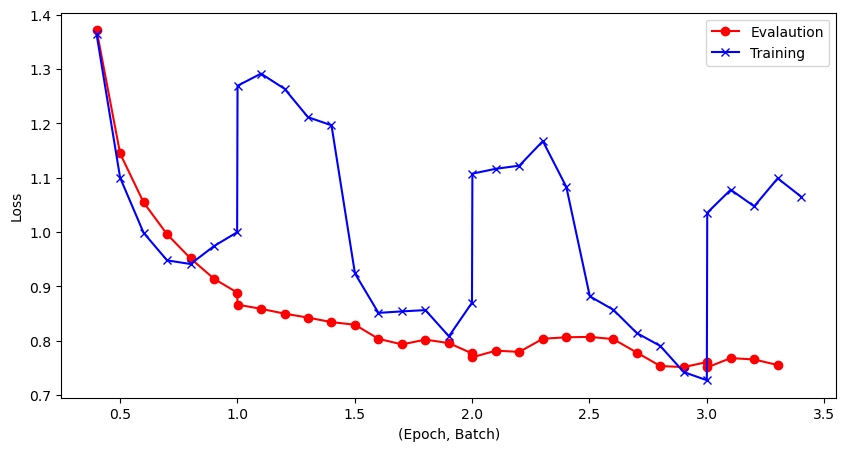

In [35]:
# tracking_loss = pd.Series(tracking_loss)
# tracking_loss_ev = pd.Series(tracking_loss_ev)

plt.figure(figsize=(10, 5))
plt.plot(tracking_loss_ev['Epoch'], tracking_loss_ev['loss_smoothed'], color="red", marker="o", label="Evalaution")
# plt.rolling(center=True, min_periods=1, window=10).mean().plot(
#     label="loss (moving avg)"
# )
plt.plot(tracking_loss['Epoch'], tracking_loss['loss_smoothed'], color="blue", marker="x", label="Training")
# plt.rolling(center=True, min_periods=1, window=10).mean().plot(
#     label="loss (moving avg)"
# )

plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

Good news, the loss is going down! This is an encouraging start, especially since we haven't done anything fancy yet.

### Save the model
We have the model loaded in memory already, so we don't really need to save the model, but it's often useful to do this so we can use it again later. 

Here's how:

In [36]:
torch.save(model, "model.pth")

## 7. Evaluation
So far, not so bad. We've shown an improvement in the loss on the training set, but that tells us little about how our model will do on new data. Let's reload our saved model and try generating some predictions on the evaluation split we created earlier.

In [29]:
loaded_model = torch.load("model.pth")

We create the eval dataset and dataloader just like we did earlier with the training dataset and dataloader:

In [30]:
eval_dataset = ImagesDataset(x_eval, y_eval, preprocessing = custom_preprocessing)
eval_dataloader = DataLoader(eval_dataset, batch_size=64)

### Make predictions
We'll iterate through the eval dataloader in batches, just like we did for training, but this time we aren't going to need to compute gradients or update weights. For each batch, we'll do the following:
1. Run the forward pass to get the model output or logits
2. Apply a softmax function to convert the logits into probability space with range[0,1]. During training, the softmax operation was handled internally by `nn.CrossEntropyLoss`. We aren't computing the loss now because we are just doing evaluation, but we still want the predictions to be in the range[0,1]. 
3. Store the results in a dataframe for further analysis

In [31]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"].to(device))
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            # Supongamos que `preds` es tu tensor que resides en la GPU
            preds.cpu().detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df.head()

100%|██████████| 65/65 [09:57<00:00,  9.19s/it]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ011922,0.127934,0.124466,0.126055,0.119889,0.120784,0.117892,0.138468,0.124513
ZJ008720,0.127323,0.126667,0.128426,0.122550,0.124322,0.114912,0.131756,0.124044
ZJ004975,0.130297,0.121165,0.128697,0.117473,0.122069,0.120289,0.131451,0.128559
ZJ010808,0.125848,0.126890,0.129936,0.115164,0.123206,0.118658,0.136099,0.124200
ZJ015681,0.133016,0.122948,0.128076,0.126406,0.122718,0.115778,0.131734,0.119323


### Predicted labels distribution
First let's review the species distribution we saw in the training set.

In [32]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    1869
antelope_duiker     1855
civet_genet         1817
leopard             1691
blank               1660
rodent              1510
bird                1231
hog                  733
Name: count, dtype: int64

Here's the distribution of our predictions on the eval set. 

In [33]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


monkey_prosimian    3671
antelope_duiker      373
blank                 50
bird                  18
rodent                 4
hog                    3
civet_genet            3
Name: count, dtype: int64

The actual evaluation set is more evenly distributed than our predictions, so we already know there is some room for improvement here.

In [34]:
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    623
antelope_duiker     619
civet_genet         606
leopard             563
blank               553
rodent              503
bird                410
hog                 245
Name: count, dtype: int64

In [35]:

# Obtener la columna de la etiqueta verdadera (la columna que tiene el valor 1)
true_labels = y_eval.idxmax(axis=1)

# Obtener la columna de máxima probabilidad de eval_preds_df
predicted_labels = eval_preds_df.idxmax(axis=1)

# Comparar las etiquetas verdaderas con las predichas
correct_predictions = (true_labels == predicted_labels)

# Filtrar las filas que no coinciden
incorrect_rows = eval_preds_df[~correct_predictions]

# Imprimir las filas incorrectas y la etiqueta correcta
for idx, row in incorrect_rows.iterrows():
    correct_label = y_eval.loc[idx][y_eval.loc[idx] == 1].index[0]
    print(f"ID: {idx}")
    print(f"Predicciones: {row}")
    print(f"Etiqueta correcta: {correct_label}")
    print()

ID: ZJ011922
Predicciones: antelope_duiker     0.127934
bird                0.124466
blank               0.126055
civet_genet         0.119889
hog                 0.120784
leopard             0.117892
monkey_prosimian    0.138468
rodent              0.124513
Name: ZJ011922, dtype: float32
Etiqueta correcta: leopard

ID: ZJ008720
Predicciones: antelope_duiker     0.127323
bird                0.126667
blank               0.128426
civet_genet         0.122550
hog                 0.124322
leopard             0.114912
monkey_prosimian    0.131756
rodent              0.124044
Name: ZJ008720, dtype: float32
Etiqueta correcta: blank

ID: ZJ004975
Predicciones: antelope_duiker     0.130297
bird                0.121165
blank               0.128697
civet_genet         0.117473
hog                 0.122069
leopard             0.120289
monkey_prosimian    0.131451
rodent              0.128559
Name: ZJ004975, dtype: float32
Etiqueta correcta: leopard

ID: ZJ011314
Predicciones: antelope_duiker     0

### Accuracy
Now let's compute how accurate our model is and compare that against some trivial baseline models. First let's get the labels with the highest score for each image.

In [36]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ011922    monkey_prosimian
ZJ008720    monkey_prosimian
ZJ004975    monkey_prosimian
ZJ010808    monkey_prosimian
ZJ015681     antelope_duiker
dtype: object

Random guessing across 8 classes would yield an accuracy of 12.5% (1/8). But we could construct a slightly better trivial model by always guessing the most common class ("monkey_prosimian" images in this case).

If we were to always guess that an image is `monkey_prosimian`, we could achieve accuracy of 15.8%.

In [37]:
eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

0.15114022319262493

Let's see how our model compares. We take the species with the highest score for each image (`eval_predictions`) and compare that to the true labels.

In [38]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.15308102862688017

Our accuracy on the evaluation set is about 50%, which is not a bad start for a very simple first pass and one epoch of training.

Let's look at the predictions from another angle. 

We can see from the confusion matrix below that our model does reasonably well on some species, but we have plenty of room for improvement on antelopes, birds, hogs and blanks.

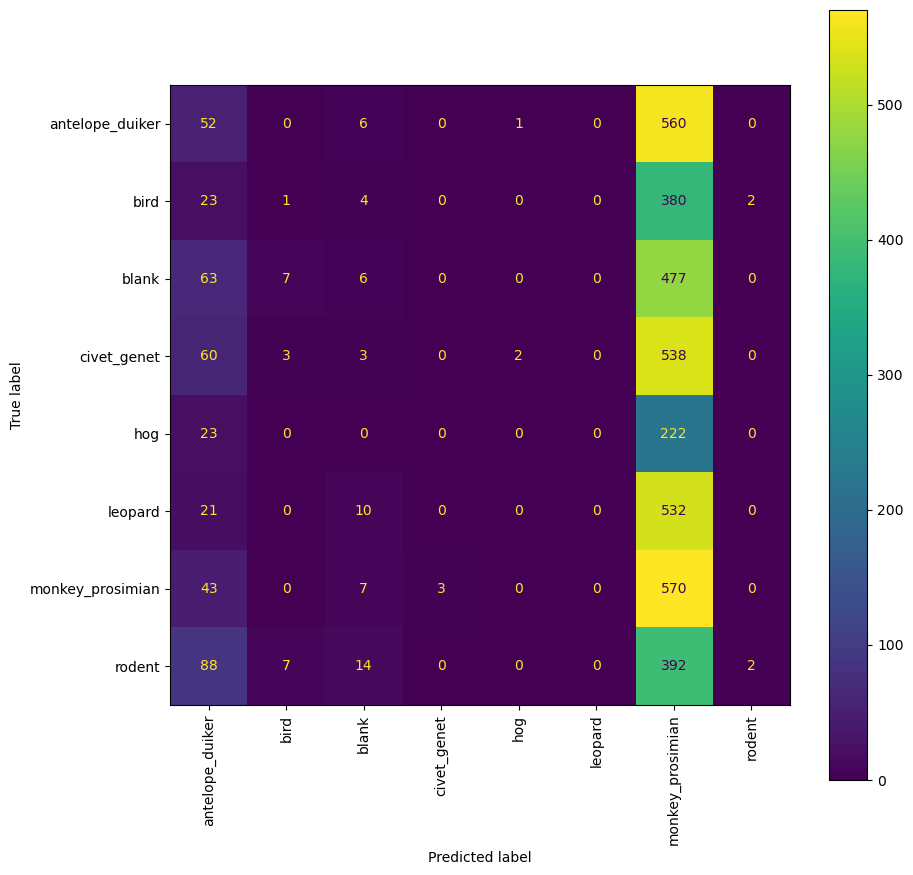

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

That's where you come in! What can you do to improve on this benchmark?

Here are some ideas you might want to try:
* Train on the full training dataset. We've only used 50% of the training data so far. Hecho!
* Train for more epochs. We've only done 1 so far. Hecho!
* Try another pretrained model. For example, you may have more success with EfficientNet, or another ResNet model with more layers like ResNet152. See what's available from pytorch [here](https://pytorch.org/vision/stable/models.html). You may also want to review which models are or have been state of the art for image classification tasks, for example on [paperswithcode.com](https://paperswithcode.com/task/image-classification). Keep in mind that different models will require different input and output dimensions, so you'll need to update how you construct `model` above.
* Experiment with different loss functions. 
* Experiment with different learning rates or learning rate schedulers. Hecho!
* Add more layers to the model head (`model.fc`). Hecho!
* You also may want to consider freezing the weights in the backbone model and only training the head (`model.fc`). If this results in higher accuracy, that suggests the current approach may be overwriting the backbone weights in a problematic way. One approach here would be to train just the model head, and then unfreeze the backbone but train at a lower learning rate. Hecho!
* Training will be much faster using GPUs, but you will need to make some small tweaks to the code. Hecho!
* As you become more comfortable iterating through different versions of the model, you may want to try out [PyTorch Lightning](https://www.pytorchlightning.ai/) or [Lightning Flash](https://lightning-flash.readthedocs.io/en/latest/quickstart.html), which build upon PyTorch and eliminate a lot of boilerplate code, in addition to providing a more complete research framework for deep learning problems.

## 8. Create submission

Last but not least, we'll want to participate in the competition and see where we stand on the leaderboard.

To do this we need to create predictions for the **competition test set** (not the eval set we used above). You don't have labels for these.

We'll create predictions in the same way we did for the `eval` set, but this time using the `test_features` we downloaded from the [competition website](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/).

In [40]:
test_dataset = ImagesDataset(test_features.filepath.to_frame(), processing= custom_preprocessing)
test_dataloader = DataLoader(test_dataset, batch_size=64)

NameError: name 'custom_processing' is not defined

In [ ]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        # run the forward step
        logits = model.forward(batch["image"].to(device))
        # apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.cpu().detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

submission_df = pd.concat(preds_collector)
submission_df

Let's check a couple things on `submission_df` before submitting to the platform. We'll want to make sure our submission's index and column labels match the submission format. (The DrivenData platform will do these data integrity checks as well, but it will be quicker to detect problems this way.)

In [ ]:
submission_format = pd.read_csv("submission_format.csv", index_col="id")

assert all(submission_df.index == submission_format.index)
assert all(submission_df.columns == submission_format.columns)

Looks like we're ready to submit! Save the dataframe out to a CSV file and then upload it via the [Submissions page](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/submissions/) on the competition website.

In [ ]:
submission_df.to_csv("submission_df.csv")

How did we do? We should get a score of ~1.8, though your results may differ slightly due to non-determinism in model training. (For reference, a randomly generated submission yields a score of something like ~2.4.)

![benchmark submission](https://drivendata-public-assets.s3.amazonaws.com/conservision-benchmark-score.jpg)

Now it is up to you to improve on this benchmark!

Head over to the [competition](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/) for data and more background info, or the [competition forum](https://community.drivendata.org/c/conser-vision/87) if you have any questions. Good luck!